In [1]:
import time
start_time=time.time()

Abstract

Se presenta un ajuste polinomial (0-6 ord) a los datos observacionales para investigar movimientos a gran escala (detrended data) en direciones X y Y.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

import itertools
from scipy.interpolate import interp1d
from scipy import interpolate

from SABReXX import sosf,acf,psk,ps,sosfnorm,sosfw,sosfw2,sosfs,sosfnorms,sfwh,pst
from CorrPoldef import CPV,CPH
from LRdefX import LR,ACLR
from Pltdef import pltdata

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

Input Data

In [3]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
lr=[6562.8,6548,6583,6717,6731]#AngstromsR
#lb=[4861.36,4958.9,5006.9]#AngstromsB


n=7

Astronomical Observations

In [4]:
inputf='595.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})


In [5]:
#LimitData
min0=75
max0=130
mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

Emission lines data

In [6]:
for i in range(1):
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-lr[Nx])/lr[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('dataII'+str(int(lr[Nx]))+'.csv')

# Muestra (i) H alfa

In [7]:
datap='dataII6562.csv'
dt=pd.read_csv(datap)
dt=dt.rename(columns={'Unnamed: 0':'No'})
dt=dt.drop('No',axis=1)
os.remove(datap)
dt.describe()

,X,Y,RV,I
count,369.00000,369.000000,369.000000,369.000000
mean,101.91600,10.555556,-1017.841296,1190.327263
std,15.88847,7.003320,15594.515616,1745.710725
min,75.09600,0.000000,-299766.779000,0.000000
25%,88.50600,5.000000,-213.594837,269.400000
50%,101.91600,11.000000,-204.641445,533.400000
75%,115.32600,15.000000,-196.555984,1159.000000
max,128.73600,22.000000,-177.781268,9957.000000


In [8]:
wd=dt.X.max()-dt.X.min()
hd=dt.Y.max()-dt.Y.min()
ar=wd/hd
sz=4

Statistical Data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


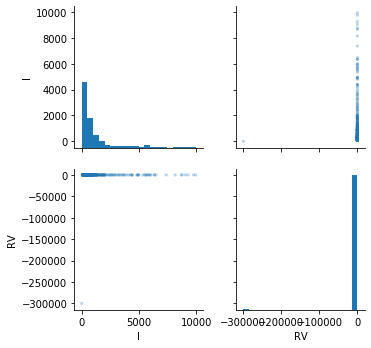

In [9]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


In [10]:
mx=(dt.RV<-100)&(dt.RV>-300)
dt=dt[mx]

In [11]:
dte=[109.96,5,-204,2420]
dte=pd.DataFrame(dte).T
dte.columns=['X','Y','RV','I']

In [12]:
dt=pd.concat([dt,dte], ignore_index=True)

In [13]:
dt.describe()

,X,Y,RV,I
count,369.000000,369.000000,369.000000,369.000000
mean,101.915995,10.555556,-206.018047,1196.885528
std,15.888467,7.003320,13.197008,1745.772479
min,75.096000,0.000000,-239.267319,54.730000
25%,88.506000,5.000000,-213.503476,270.800000
50%,101.916000,11.000000,-204.595764,537.500000
75%,115.326000,15.000000,-196.555984,1165.000000
max,128.736000,22.000000,-177.781268,9957.000000


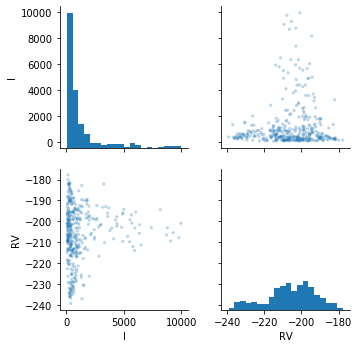

In [14]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


Emission Map

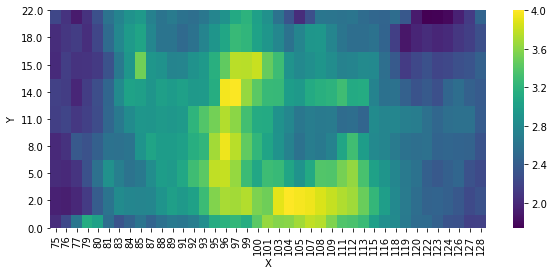

In [15]:
datal=dt.copy()
datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
#datal.Y=datal.Y.astype(int)

dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_f, cmap="viridis",xticklabels='auto')
plt.gca().invert_yaxis()
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="16"

Radial Velocity

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


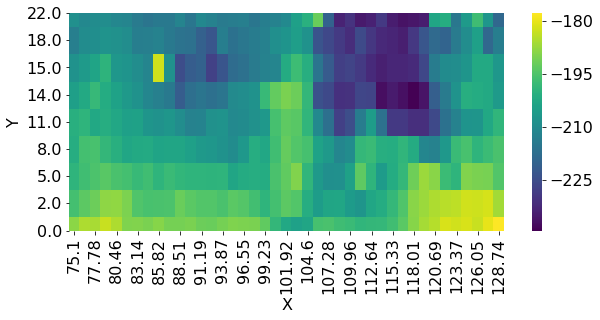

In [16]:
datal=dt.copy()
dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Weighted property

In [17]:
W=np.log(abs((dt.RV*dt.I)/dt.I.sum()))
W.head()

0   -1.943470
1   -2.757683
2   -3.220218
3   -3.543731
4   -3.586642
dtype: float64

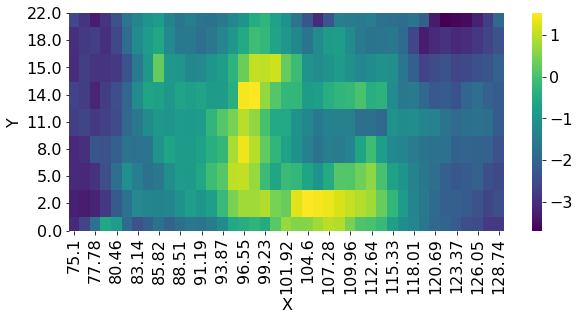

In [18]:
dtW=[dt.X,dt.Y,W]
dtW=pd.DataFrame(dtW).T
dtW.columns=['X','Y','W']

dtH_W=(dtW.round(2)).pivot(index='Y', columns='X', values='W')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dtH_W, cmap="viridis")
plt.gca().invert_yaxis()


Horizontal Polynomial Correction

 
-206
 
-0.1022 x - 195.6
         2
0.01408 x - 2.971 x - 52.95
           3          2
0.0008534 x - 0.2468 x + 23.23 x - 916.9
           4           3         2
4.461e-05 x - 0.01733 x + 2.504 x - 159.8 x + 3598
            5             4          3         2
-1.211e-06 x + 0.0006615 x - 0.1421 x + 15.01 x - 781.4 x + 1.585e+04
            6             5           4         3         2
-4.317e-07 x + 0.0002628 x - 0.06616 x + 8.818 x - 656.2 x + 2.585e+04 x - 4.214e+05


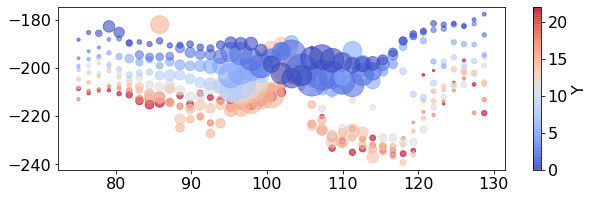

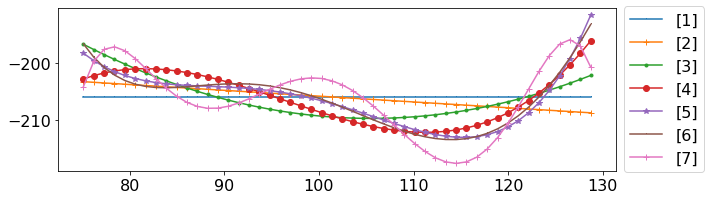

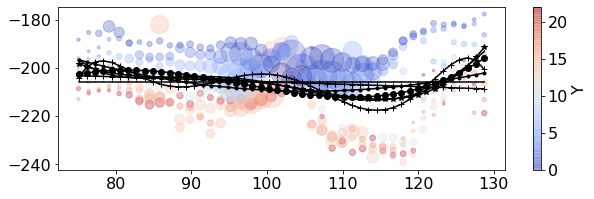

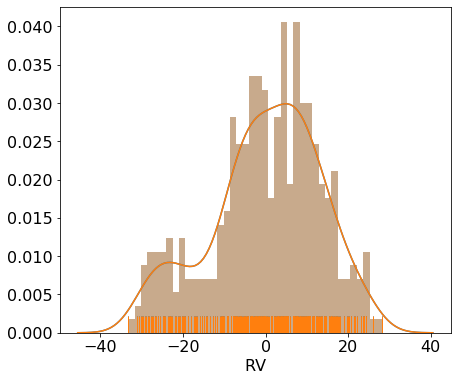

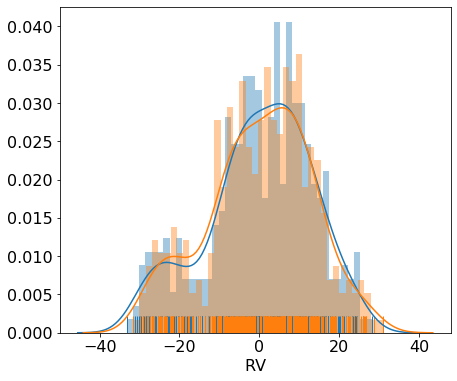

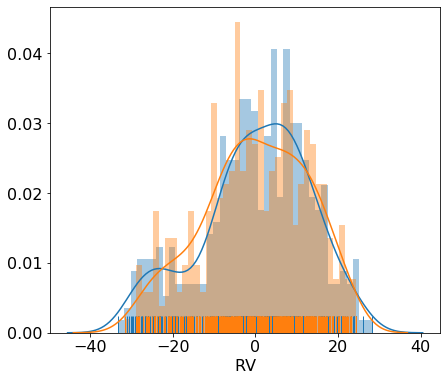

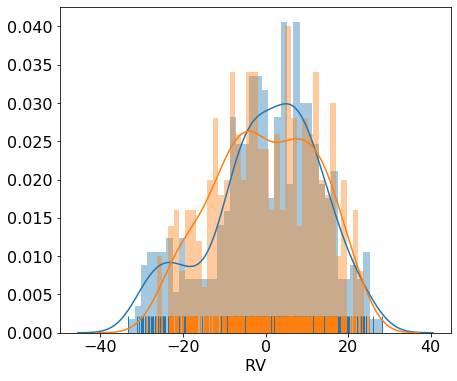

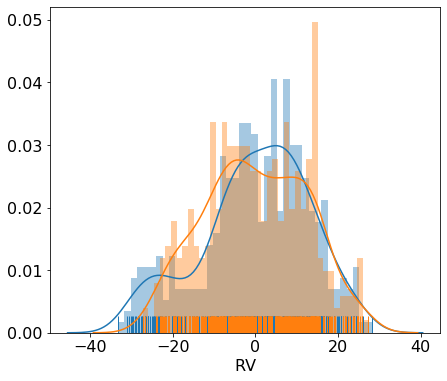

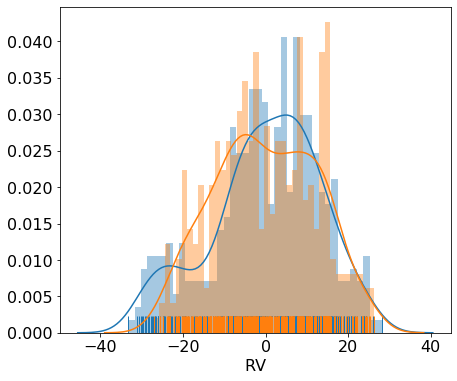

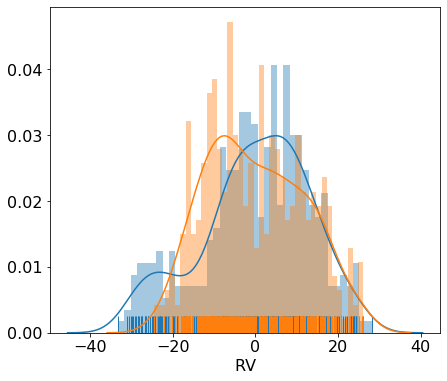

In [19]:
argo1=CPH(dt,n)

Vertical Polynomial Correction

 
-206
 
-1.306 x - 192.2
         2
0.04809 x - 2.326 x - 189.2
          3          2
0.005654 x - 0.1411 x - 0.7289 x - 191.1
         4            3          2
5.3e-05 x + 0.003326 x - 0.1094 x - 0.8649 x - 191.1
            5            4          3          2
-4.229e-05 x + 0.002339 x - 0.0397 x + 0.2188 x - 1.716 x - 190.8
           6             5           4          3         2
1.218e-05 x - 0.0008203 x + 0.02085 x - 0.2408 x + 1.188 x - 3.317 x - 190.7


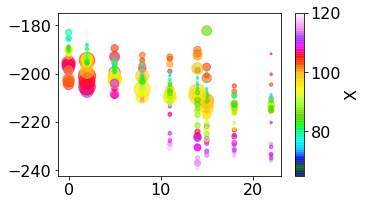

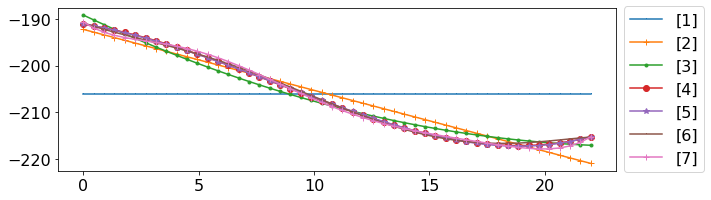

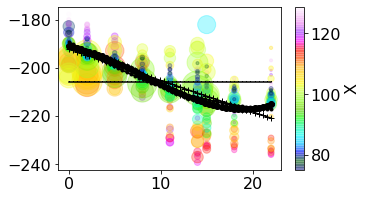

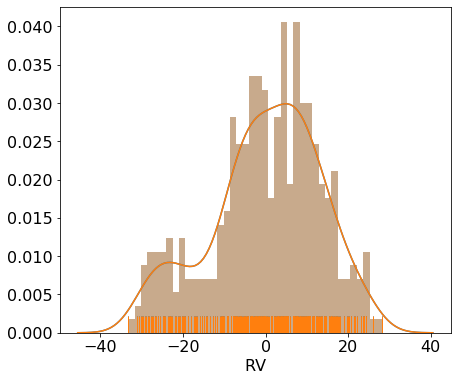

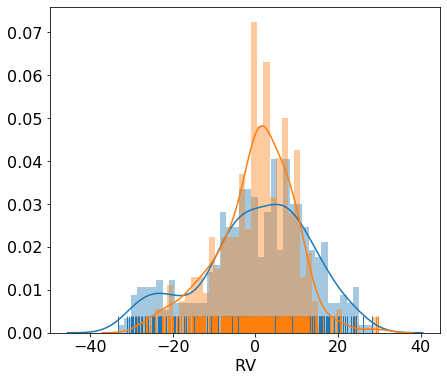

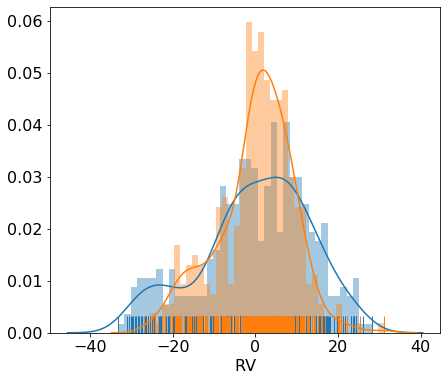

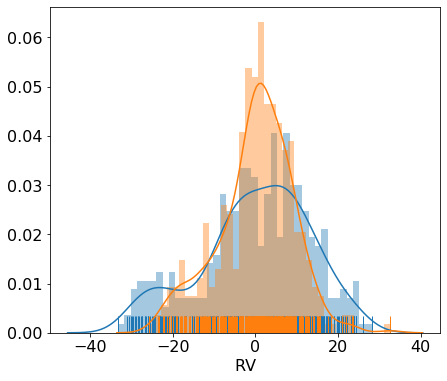

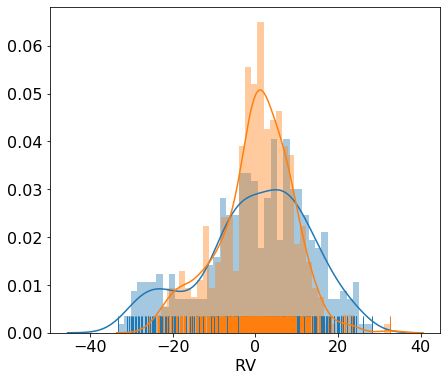

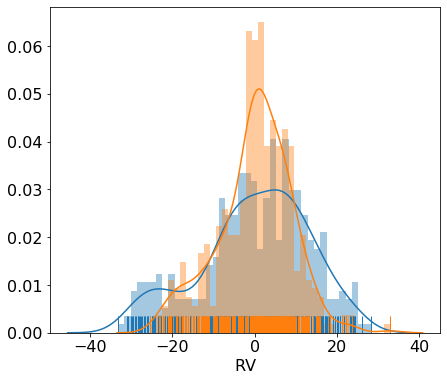

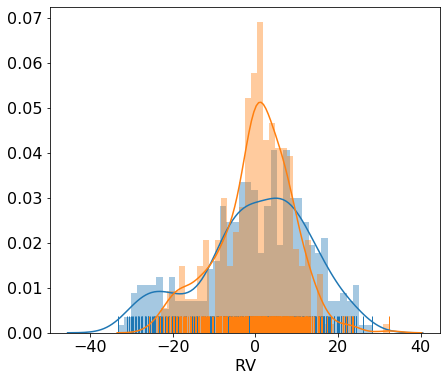

In [20]:
argo2=CPV(dt,n)

Structure Function

In [21]:
SF1=dict()

for i in range(n):
    SF1[i]=sosf(argo1[i])
    
SF2=dict()

for i in range(n):
    SF2[i]=sosf(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [22]:
xi=1
xf=15

SF1Data=dict()
SF1Pr=dict()

for i in range(n):
    SF1Data[i],SF1Pr[i]=LR(SF1[i]['Lag'],SF1[i]['Nmqvd'],SF1[i]['ErrY'],xi,xf,n)
    
SF2Data=dict()
SF2Pr=dict()


for i in range(n):
    SF2Data,SF2Pr[i]=LR(SF2[i]['Lag'],SF2[i]['Nmqvd'],SF2[i]['ErrY'],xi,xf,n)

In [23]:
SF1Data,SF2Data

({0:               R        eps     alpha  lags
  Value  0.983524  17.952882  1.158873   2.0
  Err    0.000410   0.690521  0.012413  15.0,
  1:               R        eps     alpha  lags
  Value  0.983557  17.930180  1.159457   2.0
  Err    0.000402   0.686741  0.012342  15.0,
  2:               R        eps     alpha  lags
  Value  0.984204  18.171623  1.136164   2.0
  Err    0.000414   0.699029  0.012374  15.0,
  3:               R        eps     alpha  lags
  Value  0.984603  18.381947  1.115994   2.0
  Err    0.000423   0.705538  0.012418  15.0,
  4:               R        eps     alpha  lags
  Value  0.983911  19.691920  1.071768   2.0
  Err    0.000421   0.740002  0.012078  15.0,
  5:               R        eps     alpha  lags
  Value  0.984225  19.508007  1.075425   2.0
  Err    0.000420   0.733359  0.012110  15.0,
  6:               R        eps     alpha  lags
  Value  0.984393  18.073126  1.056828   2.0
  Err    0.000649   0.715673  0.012729  15.0},
               R        ep

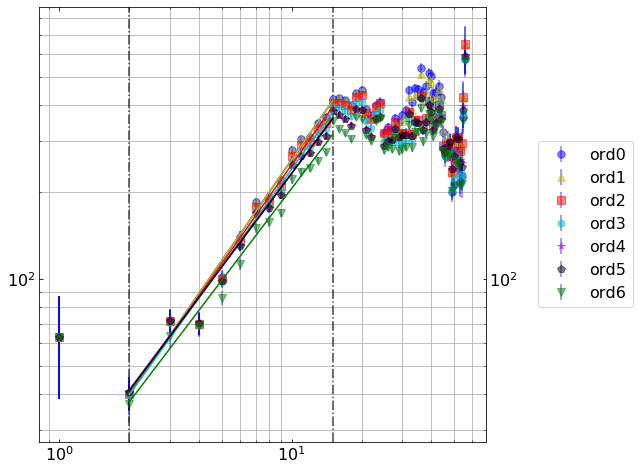

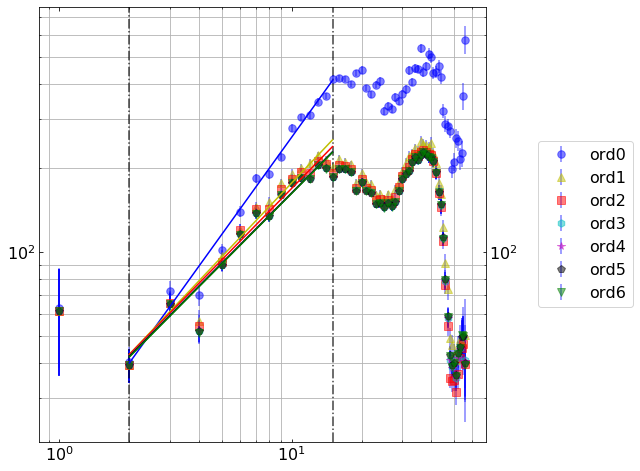

In [24]:
pltdata(SF1,SF1Pr,xi,xf,n)
pltdata(SF2,SF2Pr,xi,xf,n)

Structure Function Norm

In [25]:
SFn1=dict()

for i in range(n):
    SFn1[i]=sosfnorm(argo1[i])
    
SFn2=dict()

for i in range(n):
    SFn2[i]=sosfnorm(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:695: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [26]:
xi=1
xf=15

SFN1Data=dict()
SFN1Pr=dict()

for i in range(n):
    SFN1Data[i],SFN1Pr[i]=LR(SFn1[i]['Lag'],SFn1[i]['Nmqvd'],SFn1[i]['ErrY'],xi,xf,n)
    
SFN2Data=dict()
SFN2Pr=dict()

for i in range(n):
    SFN2Data[i],SFN2Pr[i]=LR(SFn2[i]['Lag'],SFn2[i]['Nmqvd'],SFn2[i]['ErrY'],xi,xf,n)

In [27]:
SFN1Data,SFN2Data

({0:               R       eps     alpha  lags
  Value  0.983448  0.103283  1.159178   2.0
  Err    0.000418  0.003938  0.012272  15.0,
  1:               R       eps     alpha  lags
  Value  0.983540  0.104880  1.159196   2.0
  Err    0.000429  0.004045  0.012458  15.0,
  2:               R       eps     alpha  lags
  Value  0.984264  0.112802  1.136329   2.0
  Err    0.000403  0.004290  0.012200  15.0,
  3:               R       eps     alpha  lags
  Value  0.984633  0.119494  1.115828   2.0
  Err    0.000430  0.004596  0.012457  15.0,
  4:               R       eps     alpha  lags
  Value  0.983907  0.131089  1.071751   2.0
  Err    0.000422  0.004894  0.011980  15.0,
  5:               R       eps     alpha  lags
  Value  0.984231  0.130230  1.075751   2.0
  Err    0.000430  0.004877  0.012037  15.0,
  6:               R       eps     alpha  lags
  Value  0.984483  0.131253  1.057284   2.0
  Err    0.000659  0.005195  0.012733  15.0},
 {0:               R       eps     alpha  lags


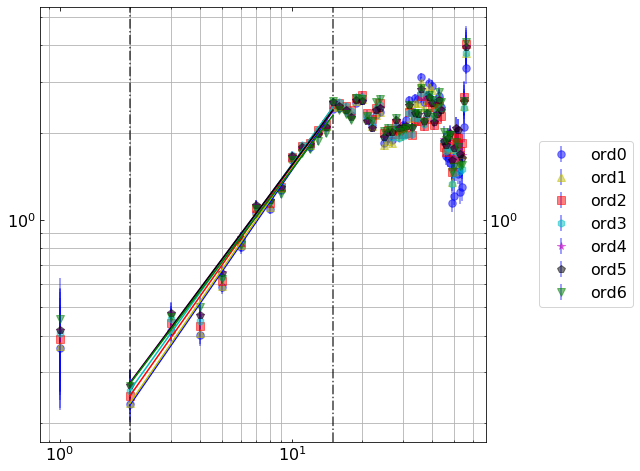

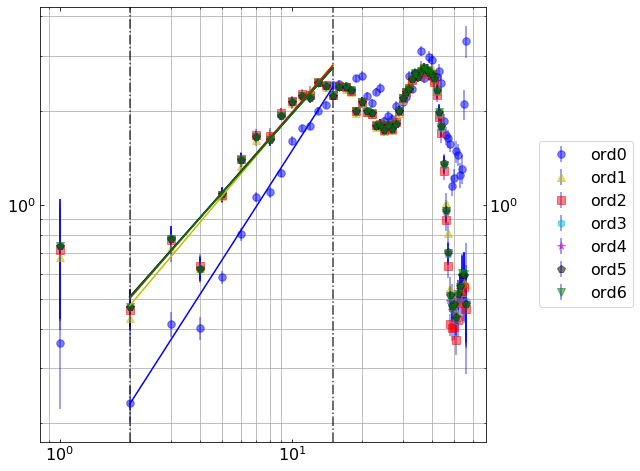

In [28]:
pltdata(SFn1,SFN1Pr,xi,xf,n)
pltdata(SFn2,SFN2Pr,xi,xf,n)

Weighted Structure Function

In [29]:
SFw1=dict()

for i in range(n):
    SFw1[i]=sosfw(argo1[i])

SFw2=dict()

for i in range(n):
    SFw2[i]=sosfw(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1171: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1180: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [30]:
xi=1
xf=15

SFW1Data=dict()
SFW1Pr=dict()


for i in range(n):
    SFW1Data[i],SFW1Pr[i]=LR(SFw1[i]['Lag'],SFw1[i]['Nmqvd'],SFw1[i]['ErrY'],xi,xf,n)
    
SFW2Data=dict()
SFW2Pr=dict()


for i in range(n):
    SFW2Data[i],SFW2Pr[i]=LR(SFw2[i]['Lag'],SFw2[i]['Nmqvd'],SFw2[i]['ErrY'],xi,xf,n)

In [31]:
SFW1Data,SFW2Data

({0:               R       eps     alpha  lags
  Value  0.722328  1.171596  0.584325   2.0
  Err    0.015268  0.062476  0.015416  15.0,
  1:               R       eps     alpha  lags
  Value  0.725112  1.210891  0.574162   2.0
  Err    0.015425  0.064757  0.015507  15.0,
  2:               R       eps     alpha  lags
  Value  0.731581  1.290842  0.580338   2.0
  Err    0.015138  0.069800  0.015808  15.0,
  3:               R       eps     alpha  lags
  Value  0.746845  1.415981  0.568901   2.0
  Err    0.014527  0.076633  0.015622  15.0,
  4:               R       eps     alpha  lags
  Value  0.730019  1.453263  0.549557   2.0
  Err    0.015379  0.077846  0.015266  15.0,
  5:               R       eps     alpha  lags
  Value  0.737997  1.466355  0.556190   2.0
  Err    0.014755  0.078526  0.015084  15.0,
  6:               R       eps     alpha  lags
  Value  0.724427  1.569833  0.549607   2.0
  Err    0.014356  0.084166  0.014793  15.0},
 {0:               R       eps     alpha  lags


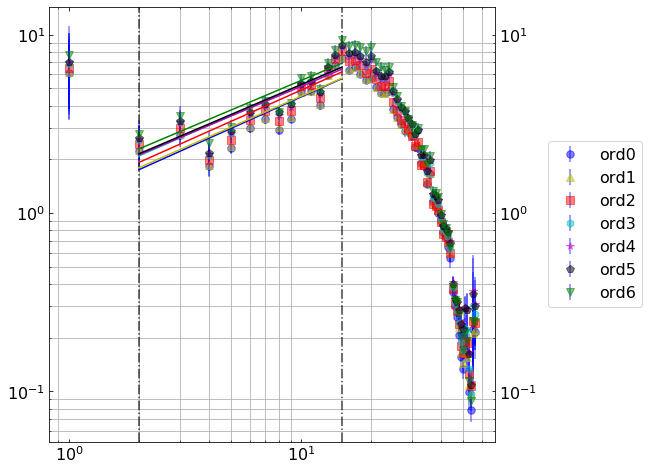

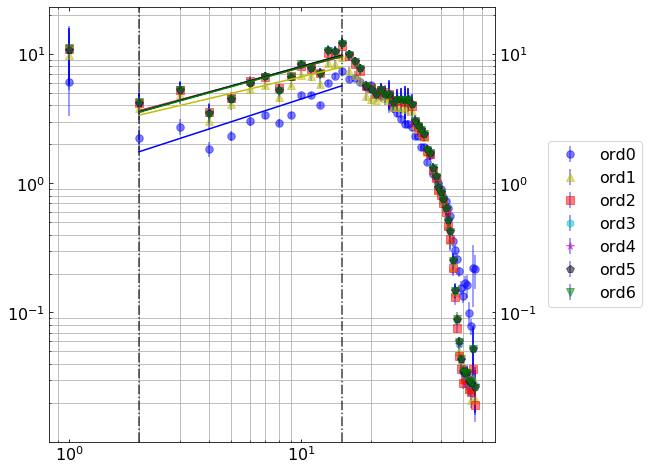

In [32]:
pltdata(SFw1,SFW1Pr,xi,xf,n)
pltdata(SFw2,SFW2Pr,xi,xf,n)

Weighted Property

In [33]:
SFwII1=dict()

for i in range(n):
    SFwII1[i]=sosfw2(argo1[i])
    
SFwII2=dict()

for i in range(n):
    SFwII2[i]=sosfw2(argo1[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1651: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1660: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [34]:
xi=1
xf=25

SFWII1Data=dict()
SFWII1Pr=dict()

for i in range(n):
    SFWII1Data[i],SFWII1Pr[i]=LR(SFwII1[i]['Lag'],SFwII1[i]['Nmqvd'],SFwII1[i]['ErrY'],xi,xf,n)
    
SFWII2Data=dict()
SFWII2Pr=dict()

for i in range(n):
    SFWII2Data[i],SFWII2Pr[i]=LR(SFwII2[i]['Lag'],SFwII2[i]['Nmqvd'],SFwII2[i]['ErrY'],xi,xf,n)

In [35]:
SFWII1Data,SFWII2Data

({0:               R       eps     alpha    lags
  Value  0.919616  0.658341  0.475229   2.000
  Err    0.004419  0.028368  0.010717  24.894,
  1:               R       eps     alpha    lags
  Value  0.923694  0.624145  0.495851   2.000
  Err    0.003949  0.026505  0.010562  24.894,
  2:               R       eps     alpha    lags
  Value  0.943918  0.405958  0.653102   2.000
  Err    0.002984  0.018031  0.010896  24.894,
  3:               R       eps     alpha    lags
  Value  0.950355  0.355903  0.700068   2.000
  Err    0.002233  0.015868  0.010900  24.894,
  4:               R       eps     alpha    lags
  Value  0.946348  0.426331  0.632630   2.000
  Err    0.002486  0.018423  0.010705  24.894,
  5:               R       eps     alpha    lags
  Value  0.948256  0.415043  0.643295   2.000
  Err    0.002101  0.017986  0.010715  24.894,
  6:               R       eps     alpha    lags
  Value  0.935911  0.475376  0.591705   2.000
  Err    0.001917  0.020330  0.010693  24.894},
 {0: 

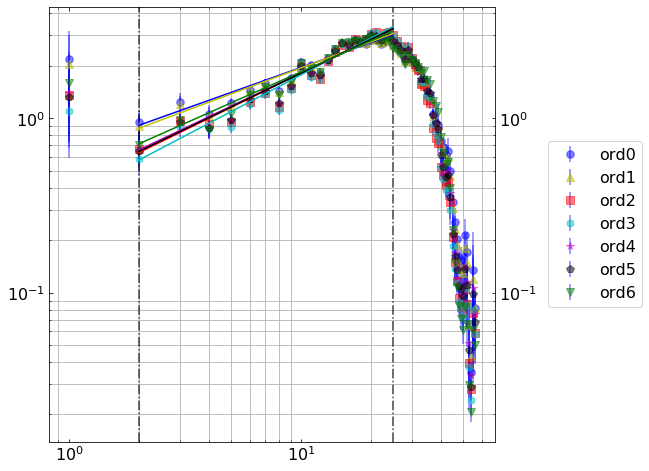

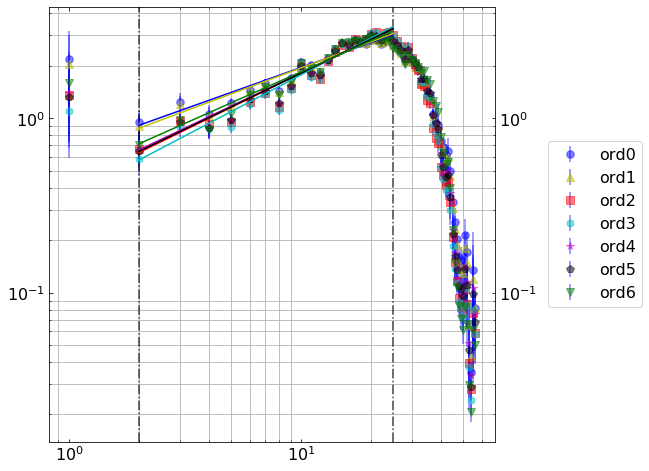

In [36]:
pltdata(SFwII1,SFWII1Pr,xi,xf,n)
pltdata(SFwII2,SFWII2Pr,xi,xf,n)

Structure Function Dr. Will

In [37]:
SFwh1=dict()

for i in range(n):
    SFwh1[i]=sfwh(argo1[i])
    
SFwh2=dict()

for i in range(n):
    SFwh2[i]=sfwh(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [38]:
xi=1
xf=25

SFwh1Data=dict()
SFwh1Pr=dict()

for i in range(n):
    SFwh1Data[i],SFwh1Pr[i]=LR(SFwh1[i]['Lag'],SFwh1[i]['Nmqvd'],SFwh1[i]['ErrY'],xi,xf,n)
    
SFwh2Data=dict()
SFwh2Pr=dict()

for i in range(n):
    SFwh2Data[i],SFwh2Pr[i]=LR(SFwh2[i]['Lag'],SFwh2[i]['Nmqvd'],SFwh2[i]['ErrY'],xi,xf,n)

In [39]:
SFwh1Data,SFwh2Data

({0:               R        eps     alpha    lags
  Value  0.914160  30.214910  0.960489   4.517
  Err    0.000044   0.957787  0.006803  17.505,
  1:               R        eps     alpha    lags
  Value  0.897472  32.354637  0.914006   4.517
  Err    0.000130   1.023365  0.006706  17.505,
  2:               R        eps     alpha    lags
  Value  0.896257  29.907301  0.941786   4.517
  Err    0.000280   0.944034  0.006195  17.505,
  3:               R        eps     alpha    lags
  Value  0.886816  30.663921  0.936741   4.517
  Err    0.000173   0.909295  0.005948  17.505,
  4:               R        eps     alpha    lags
  Value  0.854506  33.471739  0.881965   4.517
  Err    0.000041   0.967097  0.005734  17.505,
  5:               R        eps     alpha    lags
  Value  0.857053  32.456529  0.897308   4.517
  Err    0.000063   0.939449  0.005805  17.505,
  6:               R        eps     alpha    lags
  Value  0.817489  28.668687  0.901623   4.517
  Err    0.001387   1.005455  0.0

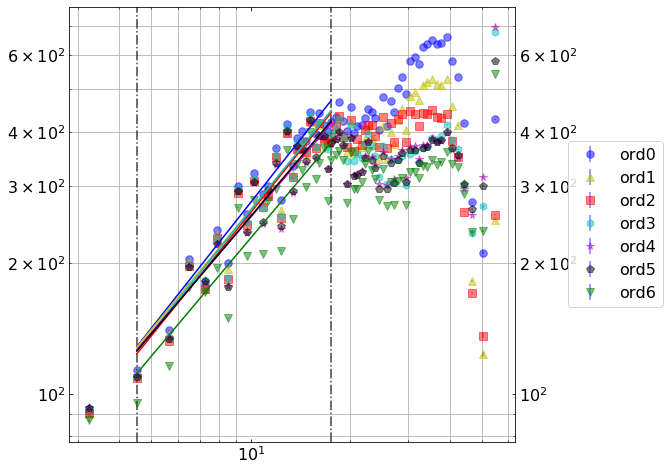

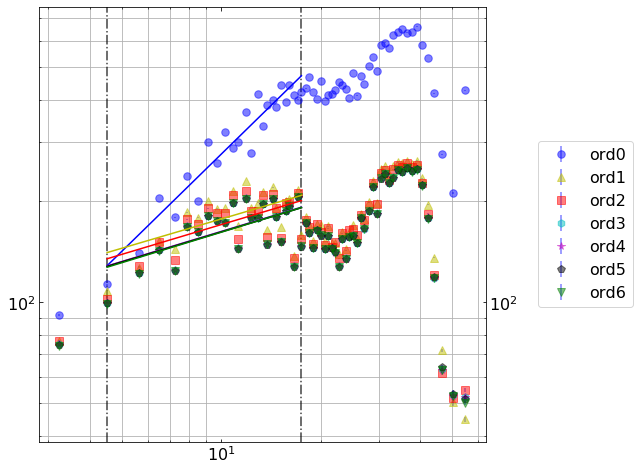

In [40]:
pltdata(SFwh1,SFwh1Pr,xi,xf,n)
pltdata(SFwh2,SFwh2Pr,xi,xf,n)

Autocorrelation Function

In [41]:
AF1=dict()

for i in range(n):
    AF1[i]=acf(argo1[i])
    
AF2=dict()

for i in range(n):
    AF2[i]=acf(argo2[i])

In [42]:
AF1Data=dict()
AF1Inter=dict()


for i in range(n):

    AF1Data[i],AF1Inter[i]=ACLR(AF1[i])
    
AF2Data=dict()
AF2Inter=dict()


for i in range(n):

    AF2Data[i],AF2Inter[i]=ACLR(AF2[i])
    

AF1Data,AF2Data 

({0: array([12.79864067, 46.72755528, 54.57599062]),
  1: array([12.39532151, 47.69753869, 53.35847041]),
  2: array([12.41717277]),
  3: array([12.28695185]),
  4: array([12.19937969]),
  5: array([12.1712061]),
  6: array([12.67260539])},
 {0: array([12.79864067, 46.72755528, 54.57599062]),
  1: array([10.3632028 , 21.63234589, 29.37840751, 44.1222972 ]),
  2: array([10.3297867 , 21.42343829, 29.39740884, 43.94341918]),
  3: array([10.54011656, 21.48152725, 29.43736942, 43.99564864]),
  4: array([10.53944295, 21.48217916, 29.43905153, 43.99567712]),
  5: array([10.54183001, 21.48747792, 29.44260891, 44.01258091]),
  6: array([10.54015224, 21.4905838 , 29.44577739, 43.99703931])})

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


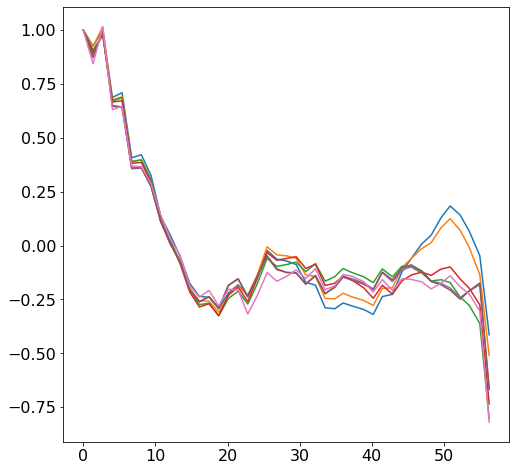

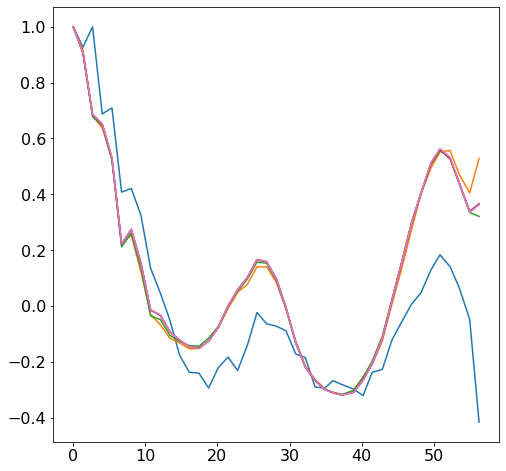

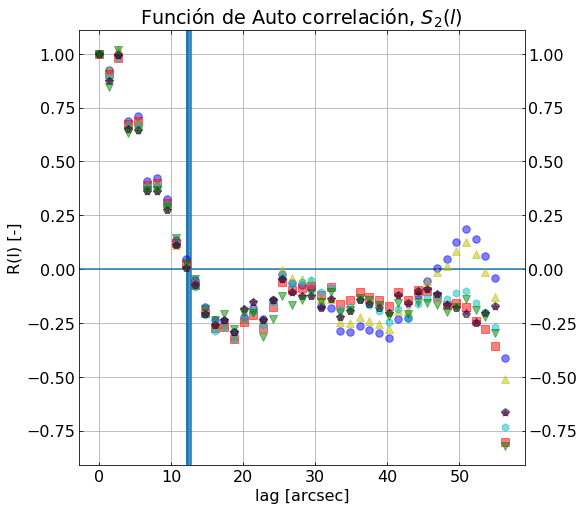

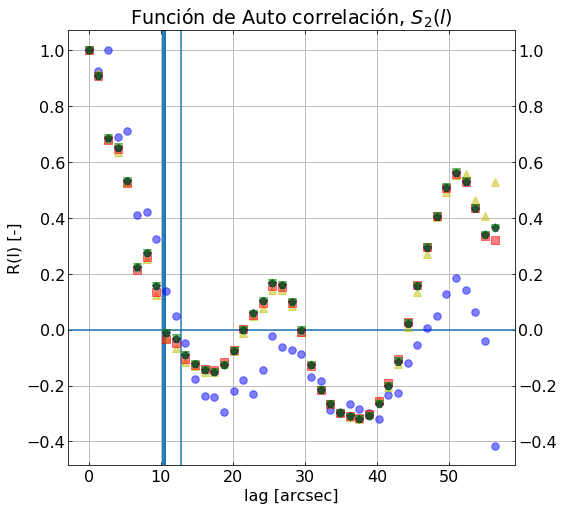

In [43]:
fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    plt.plot(AF1[i]['Lag'],AF1[i]['Nmqvd'])

fig, ax=plt.subplots(figsize=(8,8))
    
for i in range(n):
    plt.plot(AF2[i]['Lag'],AF2[i]['Nmqvd'])
    
marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF1Inter[i][0],AF1Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF1Data[y][i])



marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF2Inter[i][0],AF2Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF2Data[y][i])

1DPSD

In [44]:
PS1=dict()

for i in range(n):
    PS1[i]=ps(argo1[i])
    
PS2=dict()

for i in range(n):
    PS2[i]=ps(argo2[i])

In [45]:
xi=1
xf=20

PS1Data=dict()
mx=len(PS1[i]['k'])
PS1Pr=dict()

for i in range(n):
    PS1Data[i],PS1Pr[i]=LR(PS1[i]['k'][1:mx],PS1[i]['Pk'][1:mx],PS1[i]['Err'][1:mx],xi,xf,n)
    
PS2Data=dict()
PS2Pr=dict()

for i in range(n):
    PS2Data[i],PS2Pr[i]=LR(PS2[i]['k'][1:mx],PS2[i]['Pk'][1:mx],PS2[i]['Err'][1:mx],xi,xf,n)

In [46]:
PS1Data,PS2Data

({0:               R           eps     alpha  lags
  Value  0.884914  1.419138e+06 -2.276413   5.0
  Err    0.002787  2.024038e+05  0.026484  19.0,
  1:              R           eps     alpha  lags
  Value  0.86212  1.166286e+06 -2.179317   5.0
  Err    0.00301  1.719713e+05  0.028146  19.0,
  2:               R           eps     alpha  lags
  Value  0.864280  1.186551e+06 -2.184592   5.0
  Err    0.003013  1.769915e+05  0.028714  19.0,
  3:               R           eps     alpha  lags
  Value  0.909417  1.546399e+06 -2.294625   5.0
  Err    0.003639  2.287820e+05  0.027389  19.0,
  4:               R           eps     alpha  lags
  Value  0.915231  1.690549e+06 -2.323966   5.0
  Err    0.003396  2.569939e+05  0.028470  19.0,
  5:               R           eps     alpha  lags
  Value  0.905770  1.708018e+06 -2.342075   5.0
  Err    0.002936  2.504072e+05  0.027031  19.0,
  6:               R           eps     alpha  lags
  Value  0.887323  1.658464e+06 -2.335316   5.0
  Err    0.00387

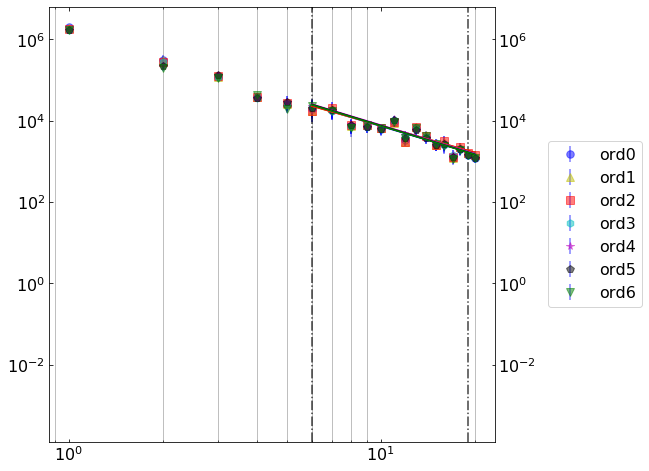

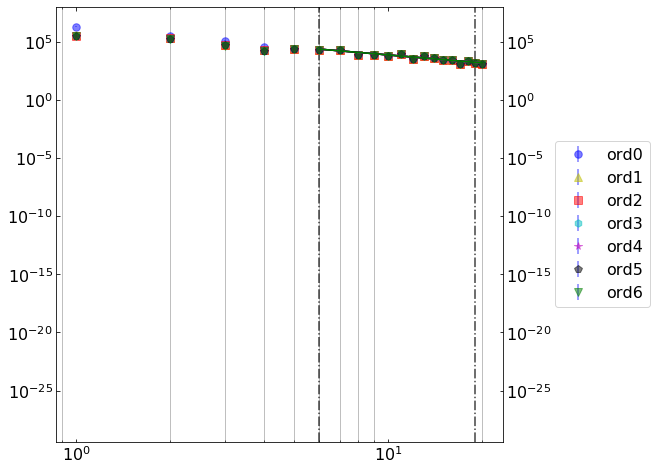

In [47]:
pltdata(PS1,PS1Pr,xi+1,xf,n)
pltdata(PS2,PS2Pr,xi+1,xf,n)

In [48]:
PS1k=dict()

for i in range(n):
    PS1k[i]=psk(argo1[i])
    
PS2k=dict()

for i in range(n):
    PS2k[i]=psk(argo2[i])

In [49]:
xi=1
xf=19

PS1kData=dict()
mx=len(PS1k[0]['k'])
PS1kPr=dict()


for i in range(n):
    PS1kData[i],PS1kPr[i]=LR(PS1k[i]['k'][1:mx],PS1k[i]['Pk'][1:mx],PS1k[i]['Err'][1:mx],xi,xf,n)
    
PS2kData=dict()
PS2kPr=dict()

for i in range(n):
    PS2kData[i],PS2kPr[i]=LR(PS2k[i]['k'][1:mx],PS2k[i]['Pk'][1:mx],PS2k[i]['Err'][1:mx],xi,xf,n)

In [50]:
PS1kData,PS2kData

({0:               R         eps     alpha   lags
  Value  0.807629  208.212326 -1.399784  0.044
  Err    0.000131    8.510097  0.012230  0.237,
  1:               R         eps     alpha   lags
  Value  0.778672  243.171856 -1.349955  0.044
  Err    0.000248    8.443442  0.014748  0.237,
  2:               R         eps     alpha   lags
  Value  0.778389  239.496217 -1.359194  0.044
  Err    0.000012    7.924940  0.015599  0.237,
  3:               R         eps     alpha   lags
  Value  0.835746  211.424280 -1.410216  0.044
  Err    0.001609    8.659941  0.013351  0.237,
  4:               R         eps     alpha   lags
  Value  0.833493  200.646722 -1.442365  0.044
  Err    0.001088    7.445703  0.015684  0.237,
  5:               R         eps     alpha   lags
  Value  0.820952  189.368292 -1.454186  0.044
  Err    0.000435    7.351752  0.014443  0.237,
  6:               R         eps     alpha   lags
  Value  0.821845  210.940037 -1.390635  0.044
  Err    0.000261   10.974246  0.

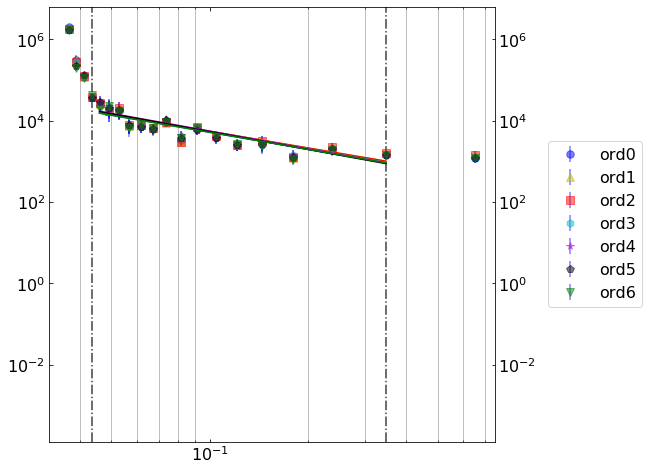

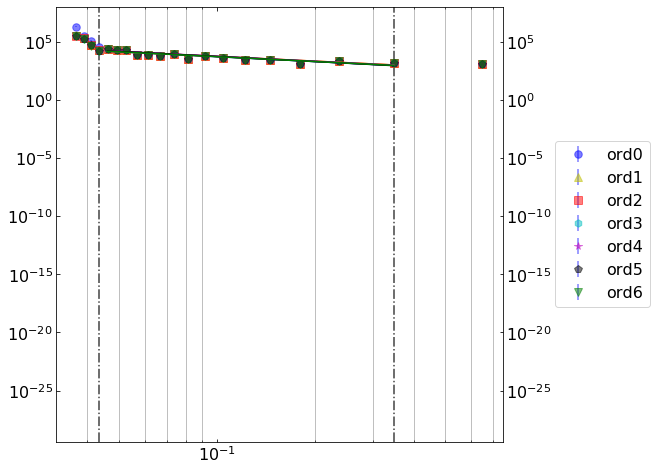

In [51]:
pltdata(PS1k,PS1kPr,xi,xf+1,n)
pltdata(PS2k,PS1kPr,xi,xf+1,n)

1DPSD Turbustat

In [52]:
PST1a=dict()
PST1b=dict()


for i in range(n):
    PST1a[i],PST1b[i]=pst(argo1[i])
    
PST2a=dict()
PST2b=dict()

for i in range(n):
    PST2a[i],PST1b[i]=pst(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/b

In [53]:
for i in range(n):
    print(PST1a[i].slope2D,PST1a[i].slope2D_err)
    


-2.6390973271041696 0.16505566878991118
-2.6462830926161947 0.19354599357776525
-2.6587705682934666 0.216130356539594
-2.4981001520639223 0.23818380165072717
-2.549880891160971 0.20530737098645746
-2.6037639009721865 0.2053844764946755
-2.6005261589280453 0.22777119107828314


In [54]:
for i in range(n):
    print(PST2a[i].slope2D,PST2a[i].slope2D_err)

-2.6390973271041696 0.18875377677017258
-2.5485937690167093 0.1953227042631085
-2.4876059874329837 0.16040829037247262
-2.1317924441828024 0.2025268129720833
-2.1960889913475388 0.17879263071355345
-2.1789939460208436 0.22050860608527156
-1.9105681458853898 0.2524261486711554


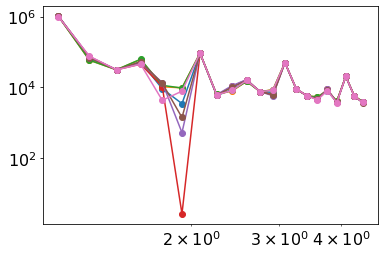

In [55]:
for i in range(n):
    plt.loglog(PST1a[i].wavenumbers,PST1a[i].ps1D,'o-', label=str(i))
    #plt.legend()

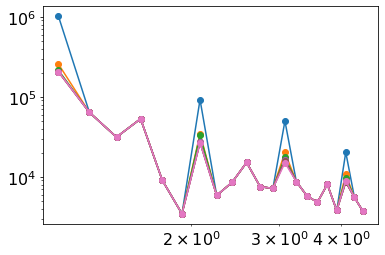

In [56]:
for i in range(n):
    plt.loglog(PST2a[i].wavenumbers,PST2a[i].ps1D,'o-', label=str(i))
    #plt.legend()

In [57]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 182.68204426765442 seconds ---


In [58]:
#SF1

In [59]:
#SF1.to_csv('SF1.csv')